# Workspace for e-chemistry 
This is the workspace for e-chemistry for the B07 and A03 project. The workspace includes CP, CA and CV analysis tools, but they only work with a special file format.
The CP class can be used from the Elias Klemm group of the University of Stuttgart and the CA and CV project from the Kristina Tschulik group of the University of Bochum.

# Packages for the Analysis tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from scipy.optimize import curve_fit
#import scipy.integrate as spi
from sdRDM import DataModel
from tabulate import tabulate
from scipy.integrate import trapz



################################################################
#imports the Analysis tools from the subfolder functions. They are in a Py file called Analysis
from functions.Analysis import Analysis,ChronoPotentiometry,MultiChronoPotentiometry,ChronoAmperometry,MultiChronoAmperometry,CyclicVoltammetry


# Datamodel from Github
The following cell loads the Datamodel from Github and stores it in the variable lib. The working with a Datamodel is until now (05.05.2023) only a β-phase. In future versions the working with a Datamodel gets more features.

In [2]:

lib = DataModel.from_markdown("specifications/Electrochemistry.md")

#lib=DataModel.from_git(url="https://github.com/FAIRChemistry/datamodel-electrochemistry.git")

In [3]:

#e_chem.analysis = [cp]
e_chem=lib.Dataset()
e_chem.electrode_setup=lib.ElectrodeSetup(CE="Pt",RE="Hg/HgO",RE_salt="KCl",RE_salt_concentration=1,RE_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
#experiment1=lib.Experiment(experiment_name="Cu12",experiment_filename="Cu12nm.DTA")
#e_chem.experiments=model.Experiment(experiment_name="test")
#e_chem.add_to_experiments([])
#lib.CP(cp_experiments=[lib.Experiment(experiment_name="exp1",experiment_filename="test.txt"),lib.Experiment(experiment_name="exp2",experiment_filename="test2.txt")])
#e_chem.experiments=[experiment1]



# analysis1=lib.Analysis(cp=[cp1,cp2])
# analysis2=lib.Analysis(ca=[cp1,cp2])
#cp_experiments=[lib.Experiment(experiment_name="exp1",experiment_filename="test.txt"),lib.Experiment(experiment_name="exp2",experiment_filename="test2.txt")]
# e_chem.analysis=analysis1
# e_chem.analysis=analysis2
#print(e_chem.analysis.yaml())

In [5]:
experiment1=lib.Experiment(name="Cu12",filename="data/Cu12nm.DTA",type=lib.enums.Experiment_type.CP.value)
experiment2=lib.Experiment(name="Cu14",filename="data/Cu14nm.DTA",type=lib.enums.Experiment_type.CP.value)
#e_chem.experiments.append([experiment1,experiment2])
e_chem.solvent=("H$_2$O")
e_chem.conducting_salt=("KOH")
e_chem.conducting_salt_concentration=(1)
e_chem.conducting_salt_concentration_unit=(lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments=[experiment1,experiment2]
#print(e_chem.experiments)

In [136]:
for experiment in e_chem.experiments:
    print(experiment.name)
    #print(i)
test=[0,1]
# print(len(e_chem.experiments))
# for i in range(0,len(e_chem.experiments)):
#     print("hallo")
#e_chem.experiments[0].name
#e_chem.experiments.name
# for ex in e_chem:
#     print(experiments[ex].name)

Cu12
Cu14


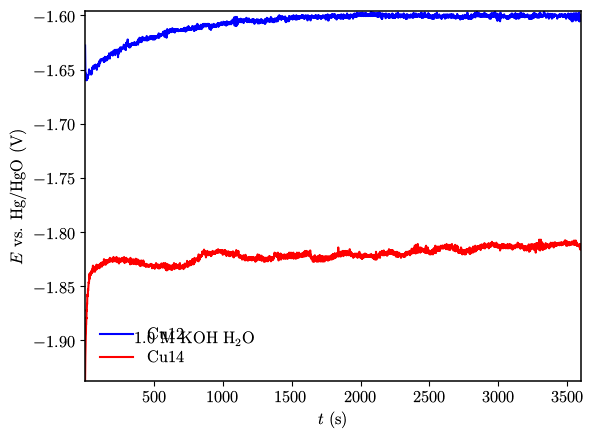

/home/dimitrios/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dimitrios/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,Name,End value
0,Cu12,-1.600205
1,Cu14,-1.821212


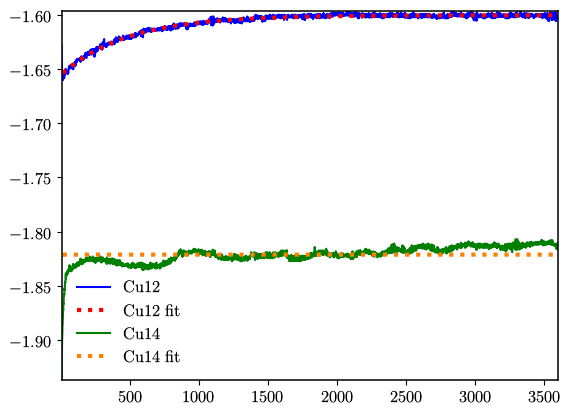

In [22]:
class MultiChronoPotentiometry:
    def __init__(self,e_chem,experiment_list,change_reference=False):
        self.reference = e_chem.electrode_setup.RE
        self.e_chem = e_chem
        self.experiment_list=experiment_list
        #self.experiments=experiments
        self.df_liste=[]
        for experiment in range(0,len(e_chem.experiments)):
            if e_chem.experiments[experiment].type=="CP":
                df = pd.read_csv(e_chem.experiments[experiment].filename, sep="\t", header=56, skiprows=[57], usecols=[2,3,4,5],names=["t","E","I","V"])
                self.df_liste.append(df)
            else:
                pass

        if change_reference:
            self.delta_E=float(input("Enter the reference differnce: "))
            self.reference= input("Enter the reference name: ")
            for df in self.df_liste:
                df['E'] = df['E'] + self.delta_E

        else:
            pass
    def quick_plot(self):
        for experiment in self.experiment_list:
            f, (ax,ax2,ax3) = plt.subplots(3,1)
            f.suptitle(e_chem.experiments[experiment].name)
            ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"])
            ax2.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["I"])
            ax3.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["V"])
            ax.set_ylabel("$E$ vs Ref (V)")
            ax2.set_ylabel("$I$ (A)")
            ax3.set_ylabel("$V$ (V)")
            ax3.set_xlabel("$t$ (s)")
            ax.get_xaxis().set_visible(False)
            ax2.get_xaxis().set_visible(False)
    def plot(self,annotate_coords=None,annotate=False,save=False,label=False):
        annotate_coords= annotate_coords if annotate_coords is not None else(0.6,0.1)
        xlabel="$t$ (s)"
        ylabel=f"$E$ vs. {self.reference} (V)"
        if label:
            xlabel= input("enter new xlabel: ")
            ylabel= input("enter new ylabel: ")
        fig, ax = plt.subplots()
        for experiment in self.experiment_list:
            ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"],label=e_chem.experiments[experiment].name)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc="best",frameon=False)
        if annotate:
            #ax.annotate((e_chem.solvent),xy=annotate_coords,xycoords="axes fraction")
            ax.annotate(f"{e_chem.conducting_salt_concentration} {e_chem.conducting_salt_concentration_unit} {e_chem.conducting_salt} {e_chem.solvent} ",xy=annotate_coords,xycoords="axes fraction")
        plt.show()
        if save:
            plotname=input("Enter the name of the plot: ")
            fig.savefig(plotname,bbox_inches='tight') 
    def end_value_fit(self,save=False):
        def exponential_fit(x, a, b, c):
            return a * np.exp(-b * x) + c
        fig,ax =plt.subplots()
        names=[]
        end_values=[]
        for experiment in self.experiment_list:
            t_fit = np.linspace(10, self.df_liste[experiment].shape[0], self.df_liste[experiment].shape[0])
            popt, pcov = curve_fit(exponential_fit,self.df_liste[experiment]["t"], self.df_liste[experiment]["E"])
            c=popt[2]
            names.append(e_chem.experiments[experiment].name)
            end_values.append(c)
            ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"],label=e_chem.experiments[experiment].name)
            ax.plot(t_fit, exponential_fit(t_fit, *popt),linewidth=3,linestyle='dotted', label="{} fit".format(e_chem.experiments[experiment].name))
            ax.legend(loc="best",frameon=False)
            df = pd.DataFrame(list(zip(names,end_values)), columns=["Name","End value"])   
        return  df   
    def end_value(self,save=False):
        fig,ax =plt.subplots()
        names=[]
        end_values=[] 
        for experiment in self.experiment_list:
            last_values = self.df_liste[experiment].tail(100)["E"].values[0]
            average = last_values.mean()
            ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"],label=e_chem.experiments[experiment].name)
            ax.plot(self.df_liste[experiment]["t"], [average] * len(self.df_liste[experiment]["t"]), linewidth=3,linestyle='dotted', label="{} average".format(e_chem.experiments[experiment].name))
            ax.legend(loc="best",frameon=False)
            names.append(e_chem.experiments[experiment].name)
            end_values.append(average) 
            df = pd.DataFrame(list(zip(names,end_values)), columns=["Name","Average (last 50 point)"]) 
        plt.show() 
        if save:
            plotname=input("Enter the name of the plot: ")
            fig.savefig(plotname,bbox_inches='tight')  
        return  df



test=MultiChronoPotentiometry(e_chem,[0,1],change_reference=False)
test.plot((0.1,0.1),annotate=True)
#test.quick_plot()
#test.end_value()
test.end_value_fit()

# Change the style and parameter of the plots
The following cell is not needed only if you want to change some parameters of your plots

In [21]:
plt.rcParams.update({
    'figure.figsize': (6.4,4.8),     # 4:3 aspect ratio. You can change the figure size here
    'font.size' : 12,                   # Set font size to 12pt
    'axes.labelsize': 12,               # -> axis labels
    'legend.fontsize': 12,              # -> legends
    'font.family': 'serif',             # -> font family 
    'text.usetex': True,              # Latex plot rendering. If True,your plots will be rendered with Latex. But this needs extra time for rendering
     'text.latex.preamble':            # LaTeX preamble
         r'\usepackage{mlmodern}'
         #... more packages if needed
})
####################

#plt.style.use('ggplot') # You can choose ure matplotlib style

# If you prefere plotstyle like Origin use the following code:

In [20]:
##### """" For Plotstyle like Origin:
#from matplotlib import  cycler
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Verdana', 'DejaVu Sans']
# plt.rcParams['font.size'] = 15
# plt.rcParams['axes.linewidth'] = 1.1
# plt.rcParams['axes.labelpad'] = 5.0
# plot_color_cycle = cycler('color', [ '0000FE', 'FE0000', '008001', 'FD8000', '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf','000000'])
# plt.rcParams['axes.prop_cycle'] = plot_color_cycle
# plt.rcParams['axes.xmargin'] = 0
# plt.rcParams['axes.ymargin'] = 0

# Analytic tools
## Analysis class 
The Analysis class includes a list of different reference potentials and a reference_difference function. This can be used to calculate the difference between two reference potentials. The reference_difference function needs 2 strings from the reference_list() as input. If the RHE scale is involved, a new windows pops up and you need also to enter the pH value.

In [3]:
Ana=Analysis()
Ana.reference_list()
Ana.reference_difference("Hg/HgO (1 M KOH)","RHE")

Reference              Potential (V)
-------------------  ---------------
SHE                            0
RHE                           -0.059
Calomel (sat. KCl)             0.241
Calomel (3.5 M KCl)            0.25
Calomel (1 M KCl)              0.28
Calomel (0.1 M KCl)            0.334
Ag/AgCl (sat. KCl)             0.199
Ag/AgCl (3.5 M KCl)            0.205
Hg/HgO (1 M KOH)               0.14
Hg/HgO (0.1 M KOH)             0.165
Fc/Fc+                         0.4


0.7320000000000001

# Input of your metadata
The following is an example how you store your information for a measurement. It is necessary for the plot and calculation functions. GSTATIC(Potentiostat).DTA is the filename which are in the subfolder data. If your file is somewhere else you need to give the full path as input. Windows makes a lot of problems in terms of working with paths. I highly recommend you to store your data in the data subfolder. Linux and MacOs should't make any problems. 

In [121]:
cp_sample1=lib.DatasetForPlots(filename="data/Cu14nm.DTA",reference="Hg/HgO",name="Cu 12 nm",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 10")


print your stored data with:


In [8]:
cp_sample1.__dict__

{'id': 'datasetforplots0',
 'filename': 'data/Cu12nm.DTA',
 'reference': 'Hg/HgO',
 'name': 'Cu 12 nm',
 'conducting_salt': 'KOH',
 'concentration': '0.1 M',
 'solvent': 'H$_2$O',
 'pH': 'pH 10',
 'scan_rate': None,
 'substrate': None}

# ChronoPotentiometry class/ ChronoPotentiometry(metadata,change_reference=False)
This class needs the metadata from above as input. You also have the choice to change your reference system by setting change_reference=True. A windows opens up and you need to give the reference difference as input and the new reference name. By doing this all your Potential values will be changed to the new system.

In [122]:
cp_normal=ChronoPotentiometry(cp_sample1)


In [10]:
cp_change_ref=ChronoPotentiometry(cp_sample1,change_referene=False)

The CP class has the following functions:
- quick_plot() -> shows all relevant data: $U$ vs time, $I$ vs. time and $U$ of the mess cell vs time. It is only to check if your data looks good or not
- plot(save=False,label=False) -> return a plot $U$ vs time. It can be saved by setting save=True. The x and y labels can also be changed with label=True
- end_value()
- end_value_fit()

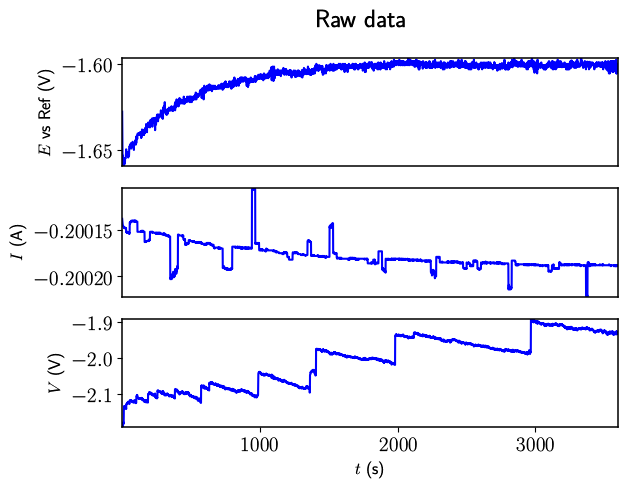

In [35]:
cp_normal.quick_plot()

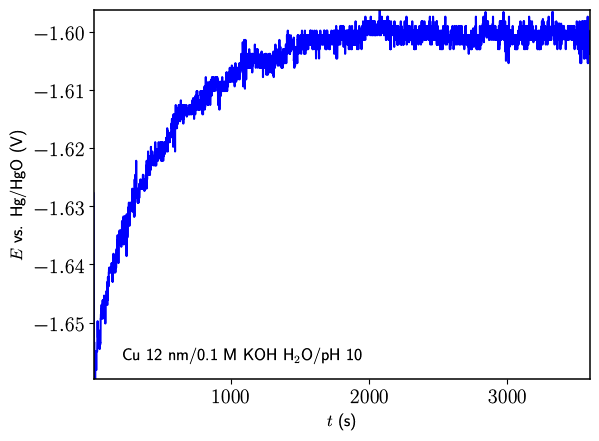

In [34]:
cp_normal.plot()
#cp_change_ref.plot()
#change the axis labels:
#cp_normal.plot(label=True)
#save it with:
#cp_normal.plot(save=True)

determine the last potential with end_value(), which return the average of the last 20 values of your measurement or with end_value_fit() which determines it via a fit function.
The end_value_fit() can be better for oscillating measurements data

/home/dimitrios/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


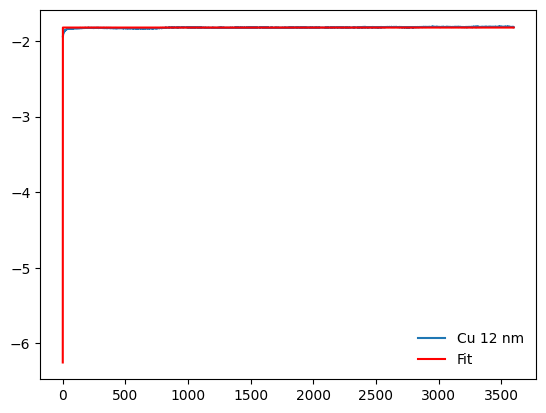

-1.8212116666666414

In [123]:
#cp_normal.end_value()
cp_normal.end_value_fit()
#cp_change_ref.end_value_fit()

# MultiChronoPotentiometry class/ MultiChronoPotentiometry([metadata,metadata2],change_reference=False)
The MultiCP class is for plotting multiple data in a single figure. It needs a list of metadata as input and has the same change_reference attribute. It only has a plot function with the same attributes (save=False and labels=False) like all plot functions.


In [31]:
cp_sample2=lib.DatasetForPlots(filename="data/Cu14nm.DTA",reference="Hg/HgO",name="Cu 14 nm",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 10")

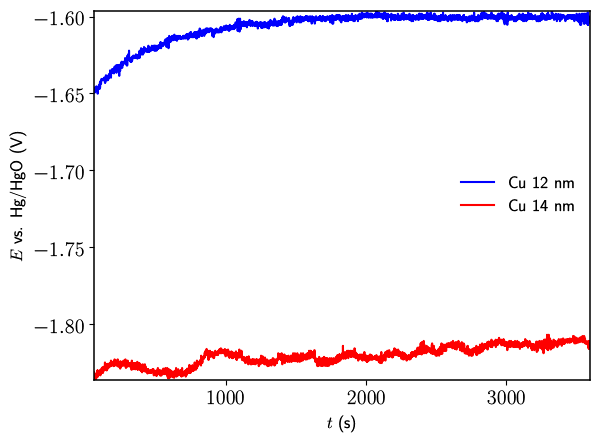

In [36]:
multicp=MultiChronoPotentiometry([cp_sample1,cp_sample2])
multicp.plot(save=False)

# ChronoAmperometry class/ ChronoAmperometry(metadata,current_density=False)
This class is very similar to the ChronoPotentiometry class it has the same input but another attribute current_density=False. By setting this on True you will be able to work with the current density instead of the current.

In [10]:
ca_sample1=lib.DatasetForPlots(filename="data/CA.csv",reference="Ag/AgCl",name="Sample1",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 7")
ca_sample2=lib.DatasetForPlots(filename="data/CA1.dat",reference="Ag/AgCl",name="PtMe",conducting_salt="LiCLO4",concentration="5 mM",solvent="H$_2$O",)

In [11]:
ca=ChronoAmperometry(ca_sample2,current_density=True)

The CA class has the following functions:
- plot(save=False,label=False) -> return a plot $I$ vs time. It can be saved by setting save=True. The x and y labels can also be changed with label=True
- end_value()
- end_value_fit()

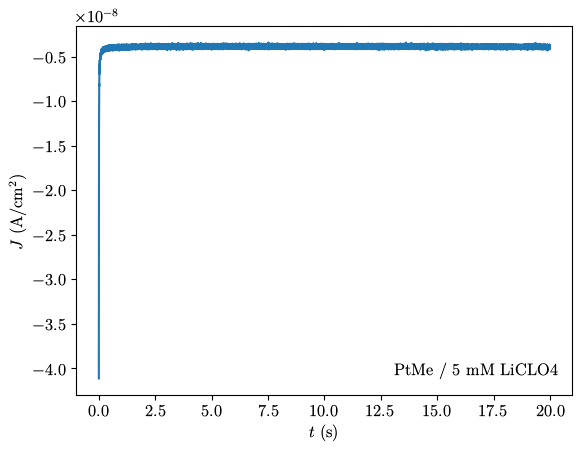

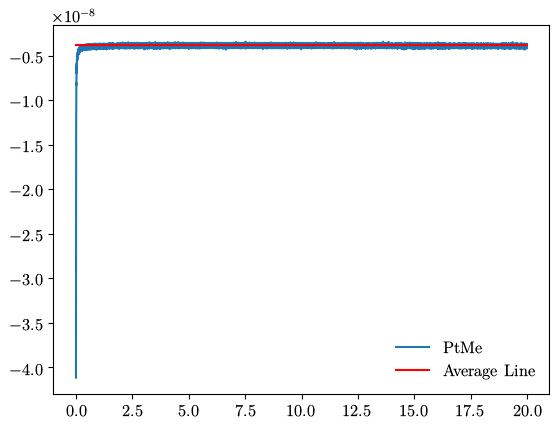

-3.796379999999999e-09

In [13]:
ca.plot()
ca.end_value(save=False)
#ca.end_value_fit()

# MultiChronoAmperometry class/ MultiChronoAmperometry([metadata,metadata2],change_reference=False)
The MultiChronoAmperometry class is for plotting multiple data in a single figure. It needs a list of metadata as input and has the same current_density attribute. It only has a plot function with the same attributes (save=False and labels=False) like all plot functions. It is similar to the MultiChronoPotentiometry class.

In [9]:
# multica=MultiChronoAmperometry([ca_sample2])
# multica.plot()

# CyclicVoltammetry class
## CyclicVoltammetry(metadata,[cycles]=None,change_reference=False,current_density=False)
The CyclicVoltammetry class is for Cyclic Voltammetry and needs also a metadata as input. An optional input are the cycles as a list. If you don't give a cycle as input then all cycles will be used. It has also the change_reference and current_density attributes as previously mentioned. The functions are:
- plot(legendposition(x,y),save=False,label=False)
- peaks(range=None) # By default it will be used the whole electrochemical windows, but you can put a range here.
- integration() # This integrates the for- and back cycle separately


In [ ]:
cv_sample=lib.DatasetForPlots(filename="data/CV.csv",reference="Ag/AgCl",name="Sample1",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 7",substrate="Au",scan_rate="20 mV/s")

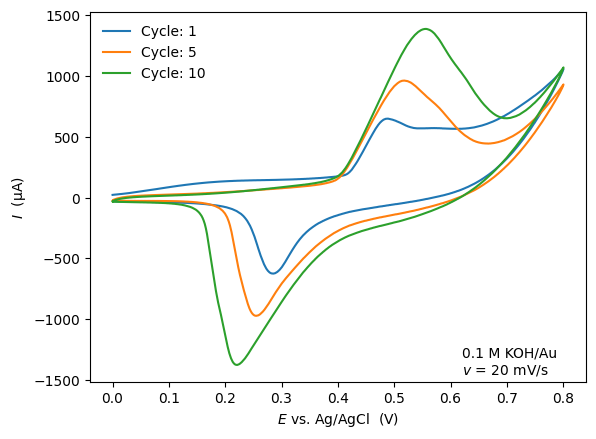

,Cycles,E min,E max,I min,I max,E1/2,I_vertex
0,Cycle: 1,0.285666,0.800433,-624.349,1056.700,0.543049,1034.3196
1,Cycle: 5,0.254962,0.517776,-971.345,961.665,0.386369,954.6959
2,Cycle: 10,0.221211,0.555431,-1374.850,1386.100,0.388321,1101.7232


In [ ]:
cv=CyclicVoltammetry(cv_sample,[1,5,10])
cv.plot()
cv.peaks()
#cv.integration()